# Project Topic

In this project, I will use Support Vector Machines (SVMs) to develop a predictive model for determining whether an individual earns more than $50,000 per year based on a diverse set of features describing their demographic and employment characteristics. This is a supervised learning problem because the training dataset will include labeled instances indicating whether the income threshold is met.

The decision to use SVMs is motivated by several factors. First, the target variable is binary, making SVMs a good choice due to their robust performance in classification tasks. Second, the dataset comprises a mix of categorical and numerical features, such as age, education level, occupation, and work hours per week. This combination of feature types offers an opportunity to explore the effectiveness of SVMs in handling mixed-data scenarios.

Additionally, SVMs are well-regarded for their ability to handle high-dimensional spaces and deliver optimal decision boundaries, even in cases where data is not linearly separable. Using the radial basis function (RBF) kernel and comparing the results from this model to a Logistic Regression, I will investigate their ability to handle non-linear data.

Beyond prediction, a significant component of this project will focus on understanding the importance of individual features as socioeconomic factors correlated with income levels. To achieve this, I will iteratively remove variables from the dataset and observe the resulting impact on model performance. This analysis will provide valuable insights into which features contribute the most to the prediction task and help uncover relationships between demographic factors and income. By examining model performance after excluding each feature, I aim to quantify its relative importance.

The project will involve several stages, including data preprocessing (e.g., handling missing values, encoding categorical variables, and standardizing numerical features), exploratory data analysis (EDA) to understand feature distributions and correlations, hyperparameter tuning to optimize SVM performance, and feature importance evaluation through the variable removal technique.

Through this project, I aim to deepen my understanding of SVMs, particularly their application in real-world classification tasks with mixed data types, while gaining insights into the socioeconomic determinants of income levels. 


First let's import some required libraries. 

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib.colors import Normalize
from sklearn.pipeline import make_pipeline
import joblib
from sklearn.metrics import classification_report
%matplotlib inline

Next let's load in the data and look at a summary. I am using a dataset from the Census Bureau in 1994. It has over 32,000 individuals described by 14 variables and labeled as making greater than or less than 50,000 per year. The dataset can be found here https://archive.ics.uci.edu/dataset/2/adult and here is the APA citation:
Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

In [2]:
df = pd.read_csv('data/adult.csv')
print('Shape of dataset (Number of observations, number of features):', df.shape)
df.info()

Shape of dataset (Number of observations, number of features): (32561, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


So we have 32,561 rows each representing one individual and 15 columns which are 14 features and the 15th column "income" is a label saying whether they make more than or less than \$50,000 per year. Here is a breif description of the features:
1. age: Numeric - Age of person
2. workclass: Categorical - Type of work
3. fnlwgt: Categorical (it is a number but not ordinal) - A control weight that corresponds to socioeconomic status from the Current Population Survey
4. education: Categorical - Highest Level of Education
5. education.num: Numeric - Highest Level of Education represented by a number
6. marital.status: Categorical - Marital Status
7. occupation: Categorical - Occupation
8. relationship: Categorical - Family relationships
9. race: Categorical - Race
10. sex: Categorical - Gender
11. capital.gain: Numeric - Amount of capital gains
12. capital.loss: Numeric - Amount of capital losses
13. hours.per.week: Numeric - Number of hours worked per week
14. native.country: Categorical - Country of origin
15. income: Categorical - The label or target indicating salary >50,000 or <=50,000



# Data cleaning

Let's take a quick look at our data to identify if we have any missing values or duplicates we need to take care of.

In [3]:
print(df.head())

   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States

**Data cleaning summary and findings**:
- From the df.info() and df.head() visualizations, we see our dataset did not contain any null values but some entries had missing values marked '?'. 2,399 of these entries were removed reducing our number of observations down to 30,162. 
- Next we checked for duplicated entries and dropped these from the dataset as well. After dropping 23 duplicated entires our final dataset has a total of 30,139 observations. Even after removing missing and duplicated data, this dataset was sufficently large that I am not going to try and impute missing values as we were left enough observations to work with.
- Regarding the features, we renamed a few to have python friendly names and removed the 'fnlwgt' column because it is hard to interpret and won't be useful to our analysis. The final dataset has 14 columns comprised of 5 numeric and 8 categorical features and one binary label. Going forward there are a couple more things we will want to do to use these features with our SVM's.
- First we will need to encode the categorical variables as integers instead of strings. 
- Second we will normalize the numeric features to have zero mean and unit variance which is recommended for optimal performance of SVM's.

In [4]:
mask = df.map(lambda x: '?' in str(x))
df = df[~mask.any(axis=1)]
print('Shape of dataset (Number of observations, number of features):', df.shape)

Shape of dataset (Number of observations, number of features): (30162, 15)


In [5]:
df = df.drop_duplicates()
print('Shape of dataset (Number of observations, number of features):', df.shape)

Shape of dataset (Number of observations, number of features): (30139, 15)


I am going to remove fnlwgt column because I am not using it in this analysis. I also want to rename columns with the '.' character, let's replace it with '_' to be more python friendly.

In [6]:
df = df.drop(columns=['fnlwgt'])
df = df.rename(columns={'education.num':'education_num',
                        'marital.status':'marital_status',
                        'capital.gain':'capital_gain',
                        'capital.loss':'capital_loss',
                        'hours.per.week':'hours_per_week',
                        'native.country':'native_country'})
print('Shape of dataset (Number of observations, number of features):', df.shape)

Shape of dataset (Number of observations, number of features): (30139, 14)


**Data cleaning summary and findings**:
- From the df.info() and df.head() visualizations, we see our dataset did not contain any null values but some entries had missing values marked '?'. 2,399 of these entries were removed reducing our number of observations down to 30,162. 
- Next we checked for duplicated entries and dropped these from the dataset as well. After dropping 23 duplicated entires our final dataset has a total of 30,139 observations. Even after removing missing and duplicated data, this dataset was sufficently large that I am not going to try and impute missing values as we were left enough observations to work with.
- Regarding the features, we renamed a few to have python friendly names and removed the 'fnlwgt' column because it is hard to interpret and won't be useful to our analysis. The final dataset has 14 columns comprised of 5 numeric and 8 categorical features and one binary label. Going forward there are a couple more things we will want to do to use these features with our SVM's.
- First we will need to encode the categorical variables as integers instead of strings. 
- Second we will normalize the numeric features to have zero mean and unit variance which is recommended for optimal performance of SVM's.

# Exploratory Data Analysis

## Pie charts for categorical variables

First, let's use pie charts to look at the distributions of our categorical features including the label.

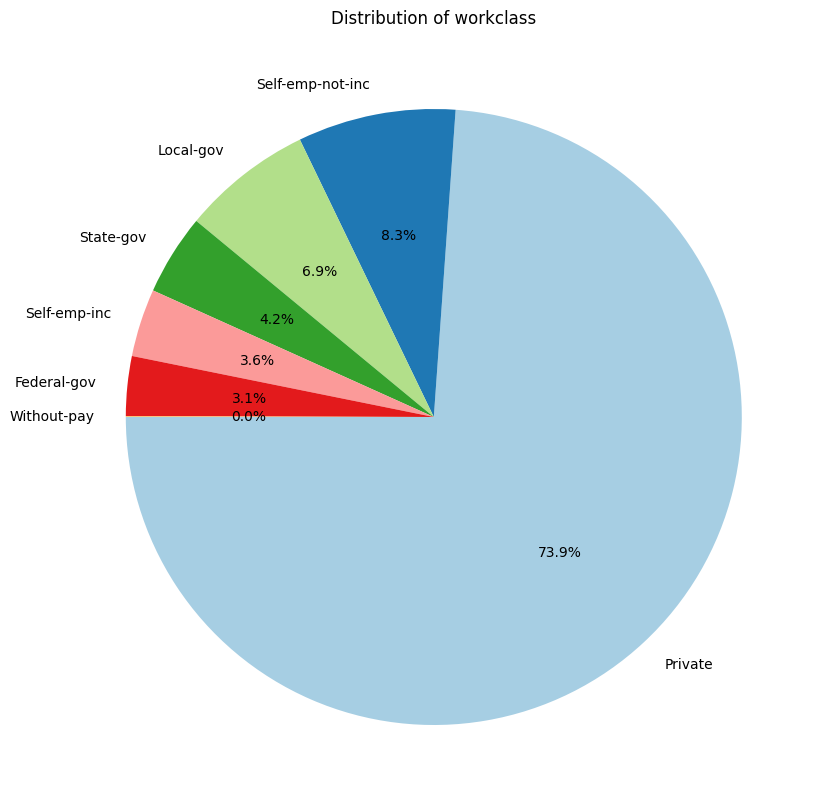

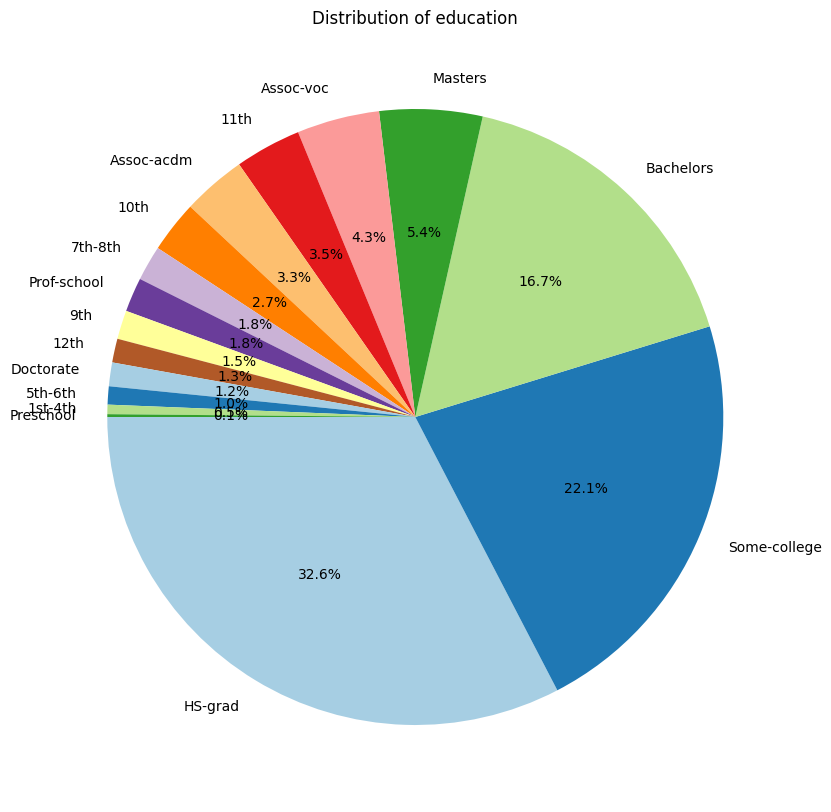

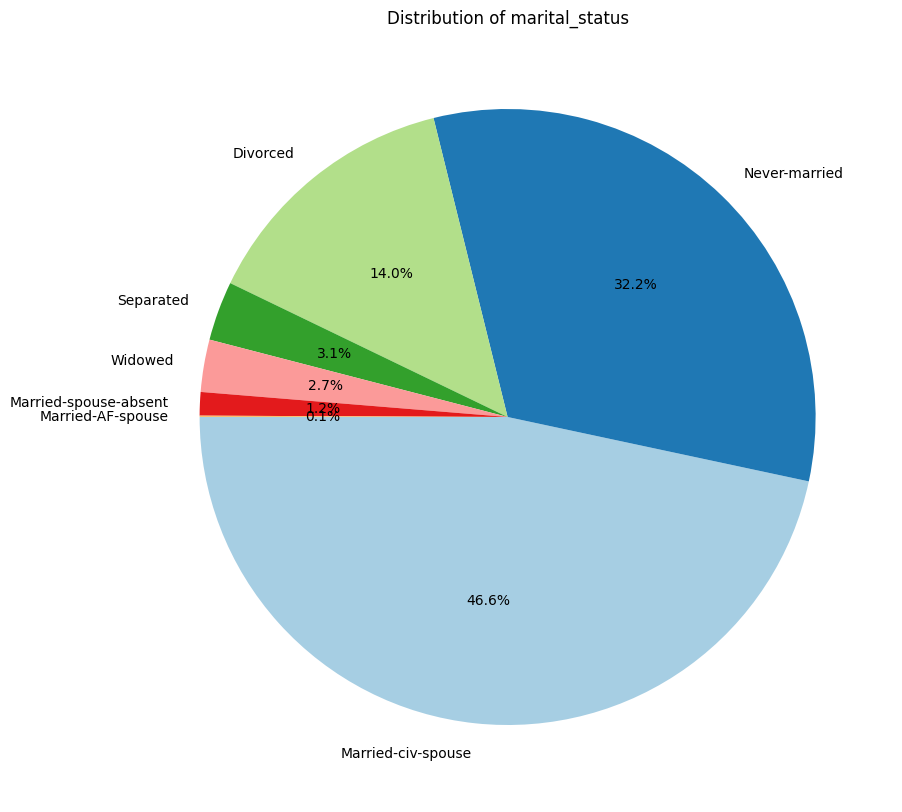

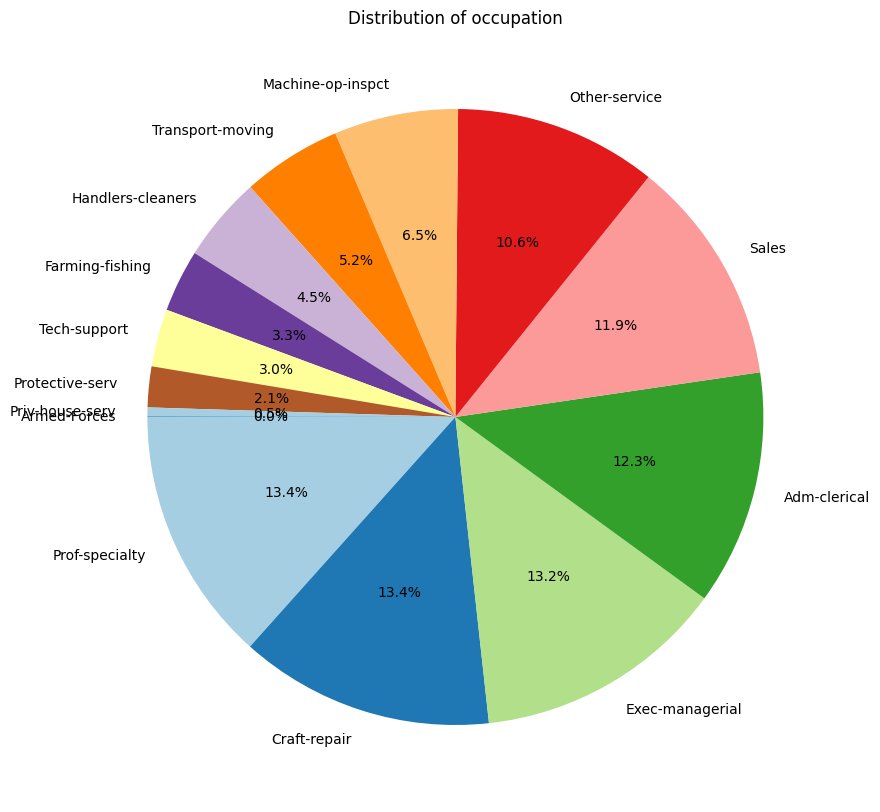

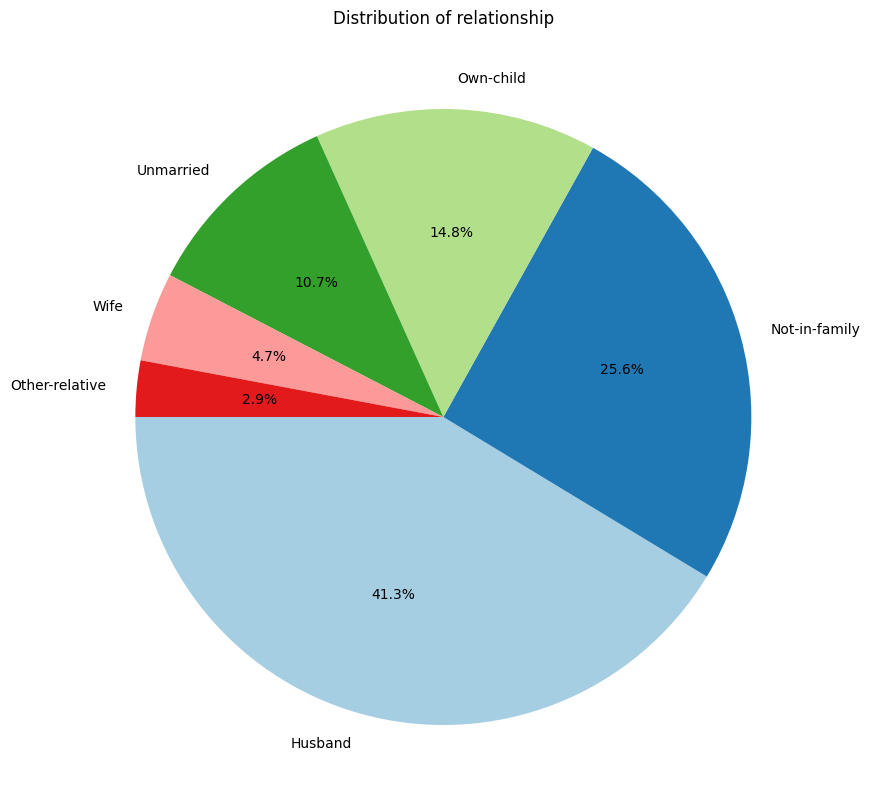

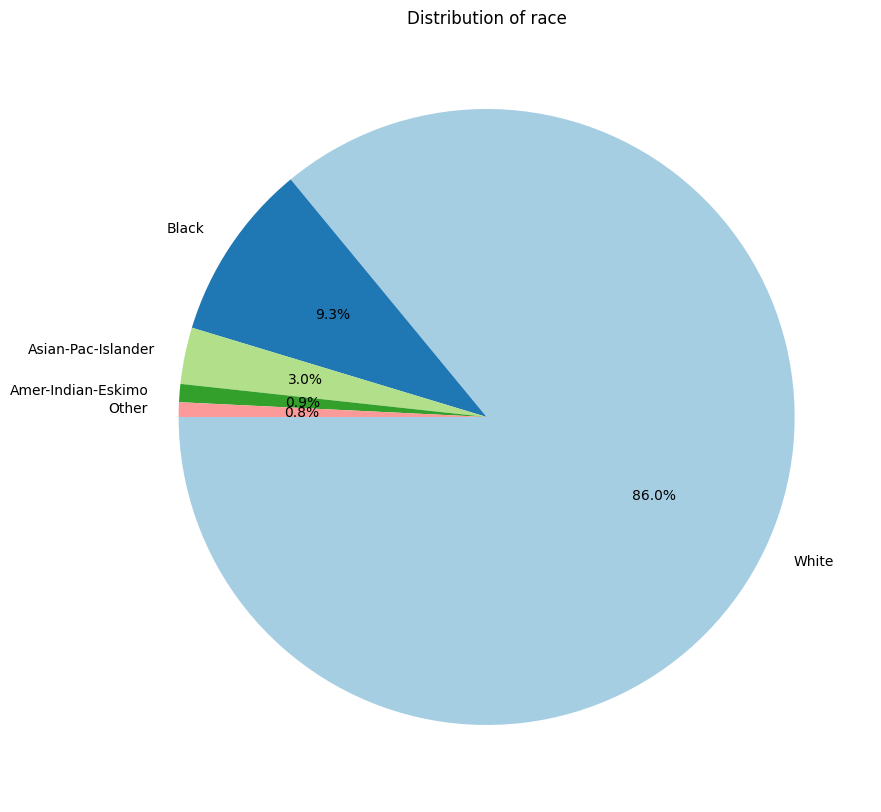

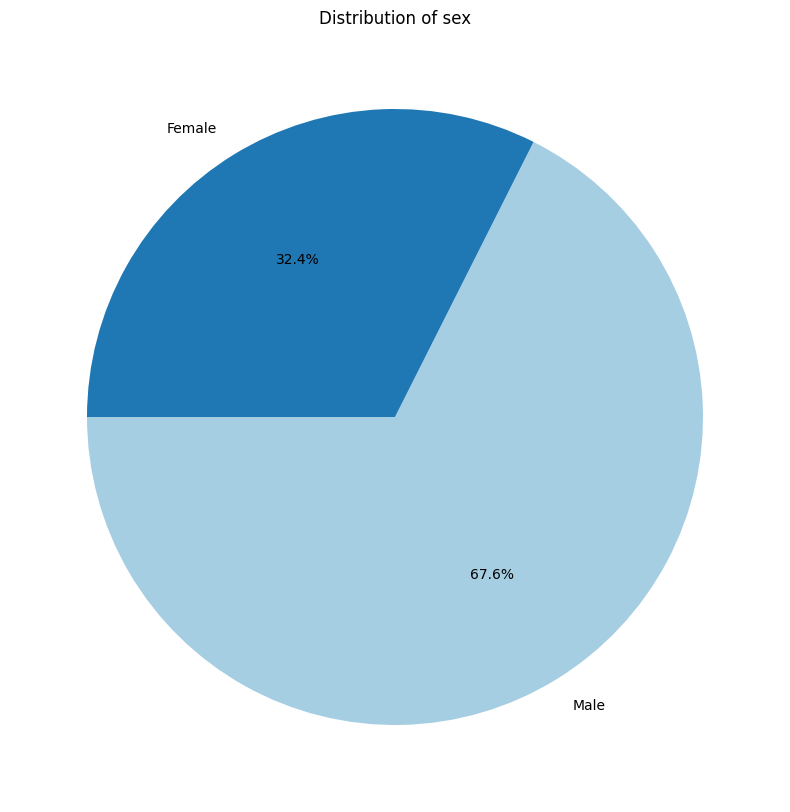

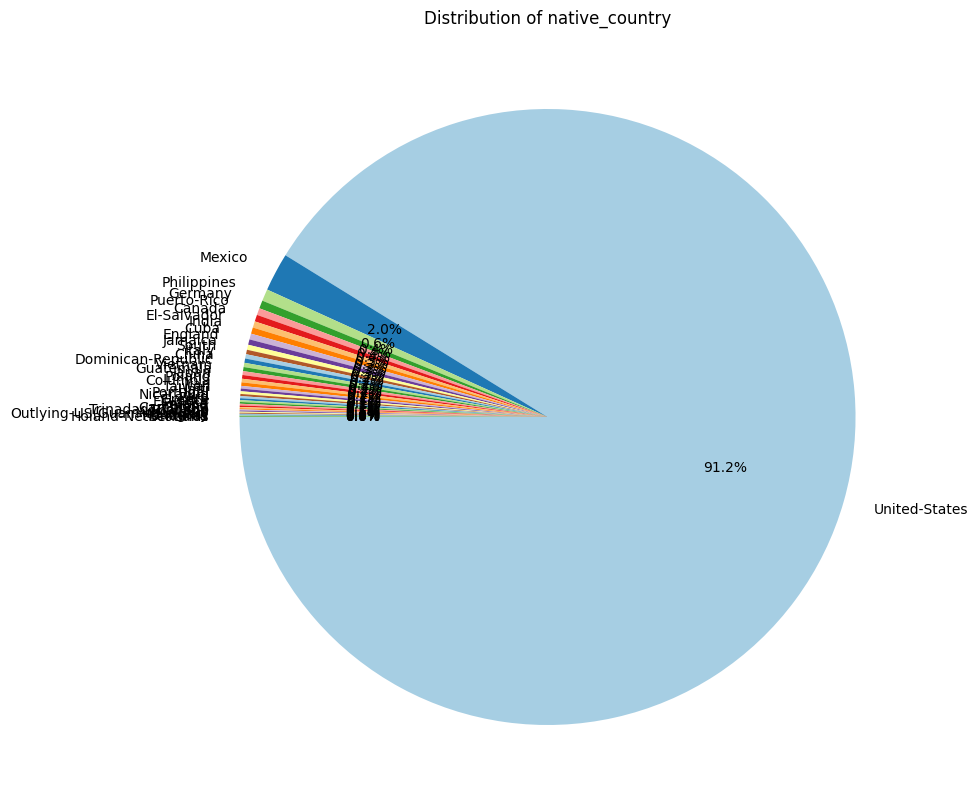

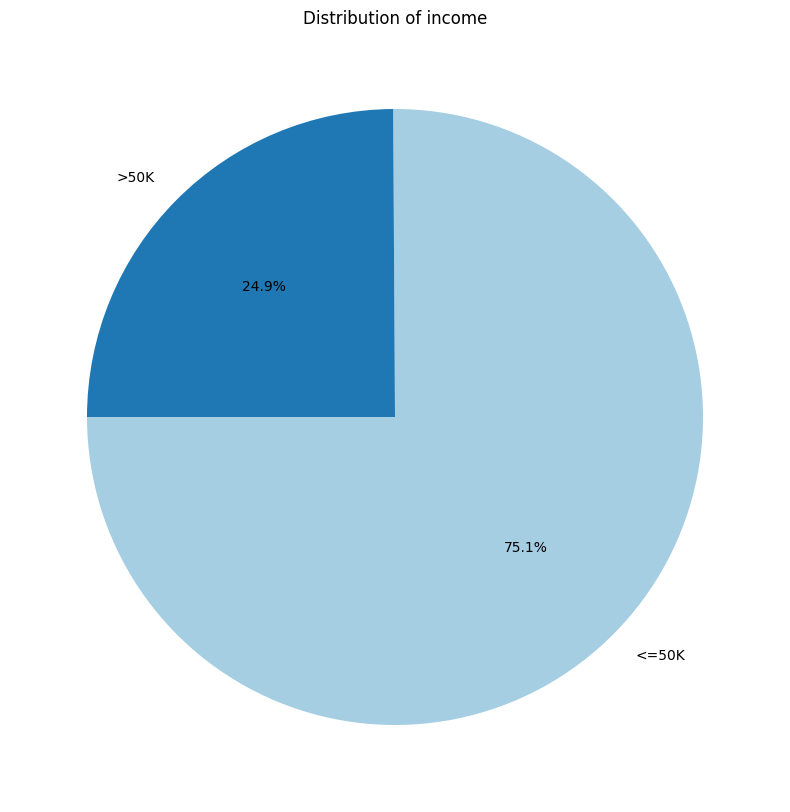

In [14]:
cat_df = df.dtypes[df.dtypes == 'object']
for column in list(cat_df.index):
    counts = df[column].value_counts()

    plt.figure(figsize=(10,10))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=180, colors=plt.cm.Paired.colors)
    plt.title(f'Distribution of {column}')

A couple things to note from these distributions are that several of them are fairly imbalanced:
 - In the workclass feature 74% are in the private sector and only 26% are in any of the remaining 6 sectors. In the race feature 86% are white and only 14% are any other race.
 -  In the sex feature 68% are male and only 32% female.
 -   In the native_country feature 91% are from the United States and only 9% are from any other country of origin.
 -    It is safe to say that this dataset is largely dominated by white males born in the United States and working in the private sector.
 -    Because these features (workclass, race, sex, and native_country) are so imbalanced, they are likely to be less important in determining income and will likely have less predictive power than the more evenly distributed features (relationship, occupation, marital_status, and education).
Another big thing to note is that our label 'income' is also imbalanced, 75% make less than 50k per yer and 25% make more than 50k per year.
- This means that accuracy may not be the best metric to analyze our models with because a model could acheive a high accuracy by simply always guessing income to be less than 50K. It would still be right 75% of the time.
- We will want to look at other metrics in addition to accuracy such as F1, precision, and Area Under Curve ROC.
- We can also set the class_weight parameter of our SVM's to 'balanced' allowing the model to focus on correctly classifying the underrepresented class.
-  One final thing we could do is experiment with oversampling the more than 50K class or undersampling the less than 50K class to make a more balanced dataset.

## Violin plots for numerical variables

We can use violin plots to visualize the distributions of our numeric variables. The width of the plots on the x-axis represents how much the dataset lies at a particular value and the range of these values is represented on the y-axis.

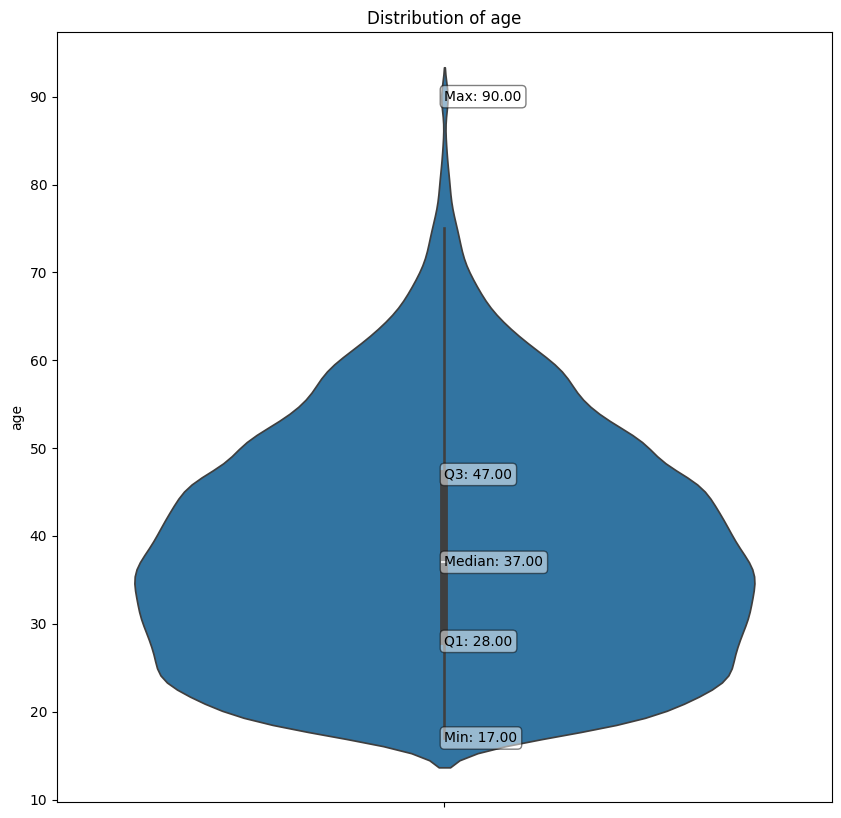

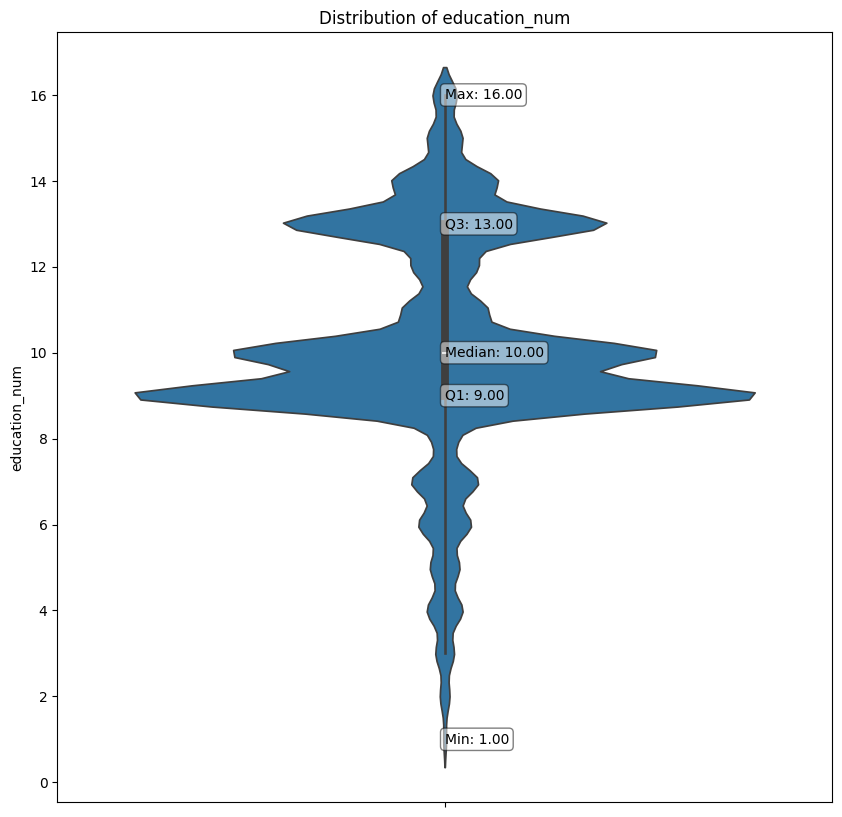

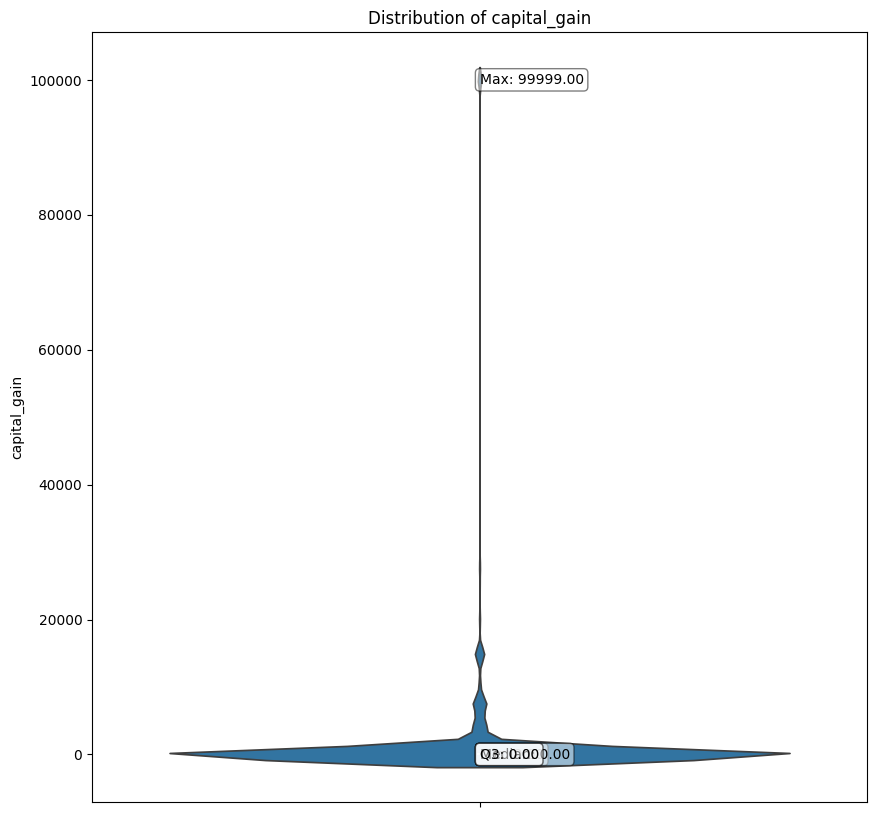

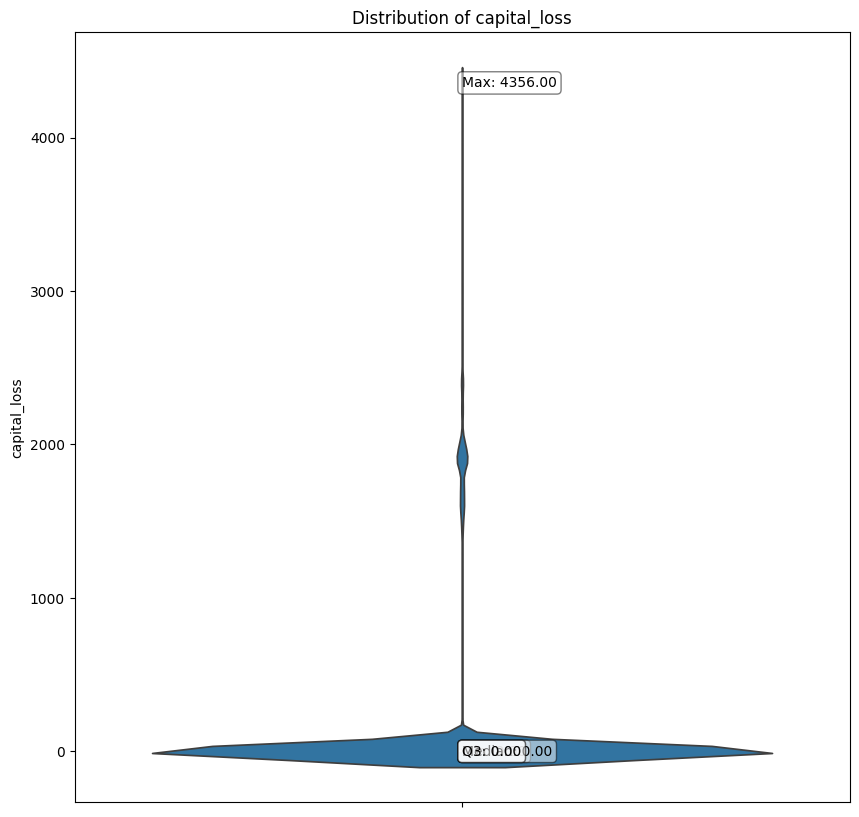

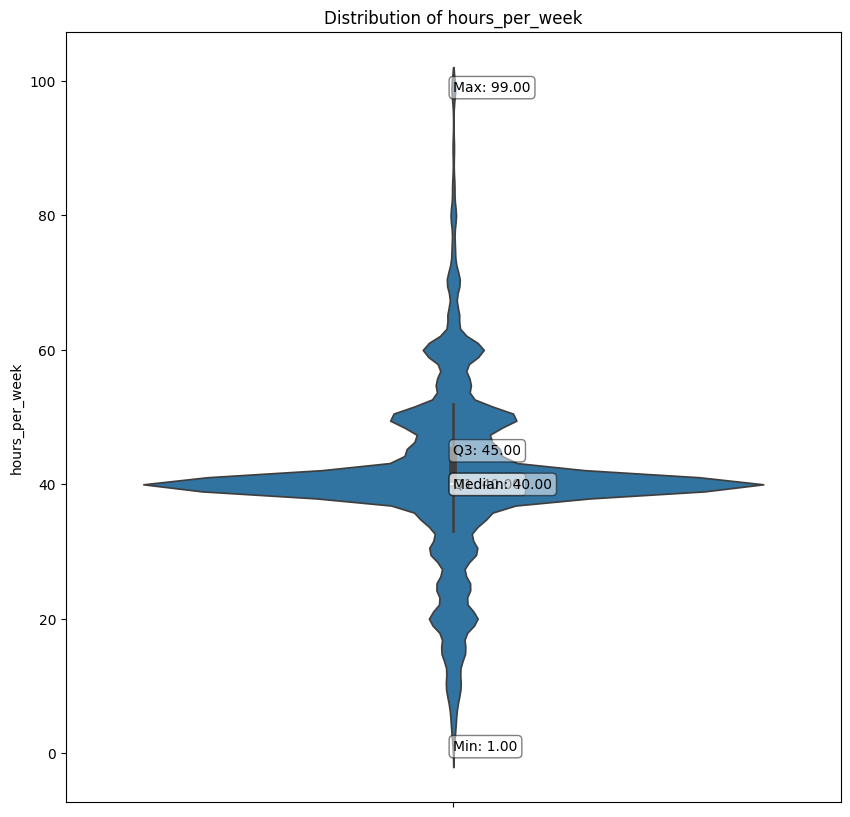

In [11]:
num_df = df.dtypes[df.dtypes == 'int64']
for column in list(num_df.index):
    plt.figure(figsize=(10,10))
    sns.violinplot(y=df[column])
    plt.title(f'Distribution of {column}')
    stats = df[column].describe()
    median = stats['50%']
    q1 = stats['25%']
    q3 = stats['75%']
    min_val = stats['min']
    max_val = stats['max']
    for value, label in zip([min_val, q1, median, q3, max_val],['Min', 'Q1', 'Median', 'Q3', 'Max']):
            
        plt.text(0, value, f"{label}: {value:.2f}", 
                 horizontalalignment='left', 
                 verticalalignment='center',
                 fontsize=10, color='black', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

    plt.ylabel(column)

Several things to note from these distributions:
- Looking at age we have a fairly even distrubtion ages 20-60 and then thinning over 60-90. This makes sense to see people entering the workforce around 18-20 and then starting to retire in their 60's. The evenness of this distribution makes me believe it will be useful in determining income.
-  Looking at education_num we have to groups that represent the majority of the distribution. The biggest group at 9-11 and another smaller group at 13-14. Comparing this to our categorical education feature, it seems that this first group corresponds to 'HS-grad'. Perhaps they are completing 9th, 10th, and 11th grades then obtaining their G.E.D. which would make them high school graduates. The second group likely corresponds to the 'some_college' category which makes sense completing 13 or 14 years education would be the first and second years of college. Smaller portions of the distribution lie in 1-8 and 15-17, which again lines up with our categorical distribution, and there seems to be enough in all regions to still be a useful feature.
-   Both capital_gain and capital_loss have big spreads (0-4500 and 0-100000) with almost all the data lying at 0. The highly skewed nature of these distrubtions makes me think they will be less useful in determining income.
-   Finally, 'hours_per_week' has a wide range from 1-99 hours per week, however 75% of the dataset lies in a small region right in the middle between 40-45 hours per week. This skew to the center is not quite as dramatic as the skew in captial_gains or capital_loss, but it still may be less useful in predicting income.

## Correlation Matrix

We can take a look at the correlation matrix for our numeric variables to see which variables correlate with each other. Darker blue will indicate lower correlation and red to white indicate higher corrleation between variables on the axis. Refer to the scale on the right side of the plot for details.

Text(0.5, 1.0, 'Correlation Matrix')

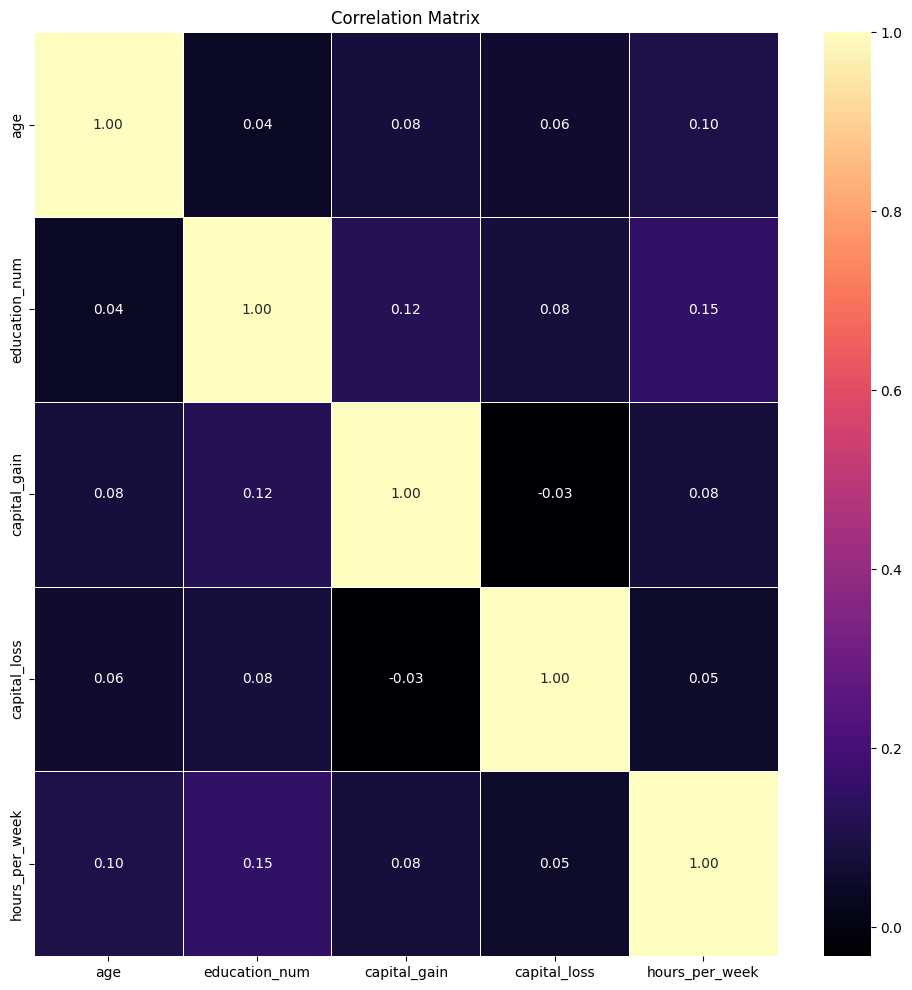

In [12]:
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')

Analysis of Correlation Matrix:
- All combinations of variables show a very weak or negligable positive correlation with the expception of captial_gain with capital_loss which shows a negligable negative correlation.
- This means as the variables increase we expect the others to increase as well. The only expception is with capital_gains and capital_loss where an increase in one signifies a decrease in the other.
- However, all of these corrleations are small enough that we shoudln't have to worry about multicollinearity, and we can treat the variables as independent.

# Models

In this section we are going to train several models and compare their performance using Area Under Curve ROC, precision, recall, F1, and accuracy:
- A baseline SVM with RBF kernel, C=1, gamma=1.
- A SVM with RBF kernel, C=1, gamma=1, class_weights='balanced' to address class imbalance.
- After a grid search to optimize hyperparameters, A SVM with RBF kernel C=bestC, gamma=bestgamma, class_weights='balanced'.
- A Logistic Regression with solver='liblinear' to see how much improve we get over a linear model.
We will also use StratifiedKFold to maintain our class imbalance in each fold of cross validation.

We need to change our categorical variables to integers and we can do this with sklearn LabelEncoder.

In [15]:
label_encoder = LabelEncoder()
categorical_columns = list(cat_df.index)
df[categorical_columns] = df[categorical_columns].apply(label_encoder.fit_transform)

Create a training set as 80% of the dataset and a testing set as the remaining 20%.

In [17]:
y = df['income']
X = df.drop(columns='income')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

To ensure the class imbalance is maintained in each fold of cross validation, we will use StratifiedKFold

In [18]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## Baseline SVM

Define pipelines for testing models. First we use StandarScaler to normalize the numeric features to zero mean and unit variance, then we define our SVM Classifier using the rbf kernel, C=1 and gamma=1 for our baseline model, and, the return probabilities parameter set to true for calculating roc_auc.

In [39]:
pipeline_baselineSVM = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=1, probability=True))

Perform Cross Validation on the Training Set

In [27]:
cv_scores = cross_val_score(pipeline_baselineSVM, X_train, y_train, cv=cv, scoring='roc_auc')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV AUC ROC:", cv_scores.mean())

Cross-Validation Scores: [0.82471755 0.8156112  0.8329545 ]
Mean CV AUC ROC: 0.8244277480484992


Train model on entire Training Set

In [24]:
pipeline_baselineSVM.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=1, probability=True))])

Test model on Test Set

In [25]:
y_pred = pipeline_baselineSVM.predict(X_test)

Evaluate Test Performance

In [26]:
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4580
           1       0.71      0.50      0.59      1448

    accuracy                           0.83      6028
   macro avg       0.78      0.72      0.74      6028
weighted avg       0.82      0.83      0.82      6028



## SVM with class weights

In [29]:
pipeline_SVMbalanced = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma=1, probability=True, class_weight='balanced'))
cv_scores = cross_val_score(pipeline_SVMbalanced, X_train, y_train, cv=cv, scoring='roc_auc')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV AUC ROC:", cv_scores.mean())
pipeline_SVMbalanced.fit(X_train, y_train)
y_pred = pipeline_SVMbalanced.predict(X_test)
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.8445633  0.84624137 0.85341911]
Mean CV AUC ROC: 0.8480745901617834

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4580
           1       0.56      0.69      0.62      1448

    accuracy                           0.80      6028
   macro avg       0.73      0.76      0.74      6028
weighted avg       0.81      0.80      0.80      6028



## SVM with Hyper Parameter Tuning

Grid Search to find optimal C and gamma values. Since this will take a long time to run, I am commenting out the code below that was used to do the grid search, and we can just load in the results in the next cell. 

In [ ]:
#pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf',class_weight='balanced', probability=True))
#ranges = {'svc__C': np.logspace(-5, 15, num=20, base=2), 'svc__gamma': np.logspace(-15, 3, num=20, base=2)}
#grid = GridSearchCV(pipeline, ranges, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
#grid.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [41]:
grid = joblib.load('grid_search_results_1.pkl')
grid

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': array([3.12500000e-02, 6.48221903e-02, 1.34461323e-01, 2.78914479e-01,
       5.78555119e-01, 1.20010272e+00, 2.48938518e+00, 5.16375679e+00,
       1...
                         'svc__gamma': array([3.05175781e-05, 5.88486327e-05, 1.13480878e-04, 2.18831078e-04,
       4.21983346e-04, 8.13732428e-04, 1.56916255e-03, 3.02589774e-03,
       5.83499594e-03, 1.12519261e-02, 2.16976741e-02, 4.18407532e-02,
       8.06836999e-02, 1.55586574e-01, 3.00025680e-01, 5.78555119e-01,
       1.11565792e+00, 2.15138117e+00, 4.14862018e+00, 8.00000000e+00])},
             scoring='roc_auc', verbose=2)

In [42]:
print("Best parameters: ", grid.best_params_)
print("Best cross-validation ROC AUC: ", grid.best_score_)

Best parameters:  {'svc__C': 32768.0, 'svc__gamma': 0.00042198334632890876}
Best cross-validation ROC AUC:  0.8995132989365224


Saving results from the grid search. Only uncomment and run if a new grid search is performed.

In [43]:
#joblib.dump(grid, 'grid_search_results_2.pkl')

In [35]:
bestC = grid.best_params_['svc__C']
bestgamma = grid.best_params_['svc__gamma']

In [37]:
pipeline_SVMtuned = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=bestC, gamma=bestgamma, probability=True, class_weight='balanced'))
cv_scores = cross_val_score(pipeline_SVMtuned, X_train, y_train, cv=cv, scoring='roc_auc')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV AUC ROC:", cv_scores.mean())
pipeline_SVMtuned.fit(X_train, y_train)
y_pred = pipeline_SVMtuned.predict(X_test)
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.89766211 0.89889807 0.90197971]
Mean CV AUC ROC: 0.8995132989365224

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      4580
           1       0.54      0.85      0.66      1448

    accuracy                           0.79      6028
   macro avg       0.74      0.81      0.75      6028
weighted avg       0.85      0.79      0.80      6028



## Logistic Regression

In [38]:
pipeline_LogReg = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear'))
cv_scores = cross_val_score(pipeline_LogReg, X_train, y_train, cv=cv, scoring='roc_auc')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV AUC ROC:", cv_scores.mean())
pipeline_LogReg.fit(X_train, y_train)
y_pred = pipeline_LogReg.predict(X_test)
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))

Cross-Validation Scores: [0.85127518 0.85056301 0.85936248]
Mean CV AUC ROC: 0.8537335575086669

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      4580
           1       0.51      0.75      0.61      1448

    accuracy                           0.77      6028
   macro avg       0.71      0.76      0.72      6028
weighted avg       0.81      0.77      0.78      6028



# Results and Analysis

Add table with results from different models
Show Heatmap for grid search again.
Summarize the results and takeaways

## Visualizing Grid search results (code adapted from week 6 assignment).

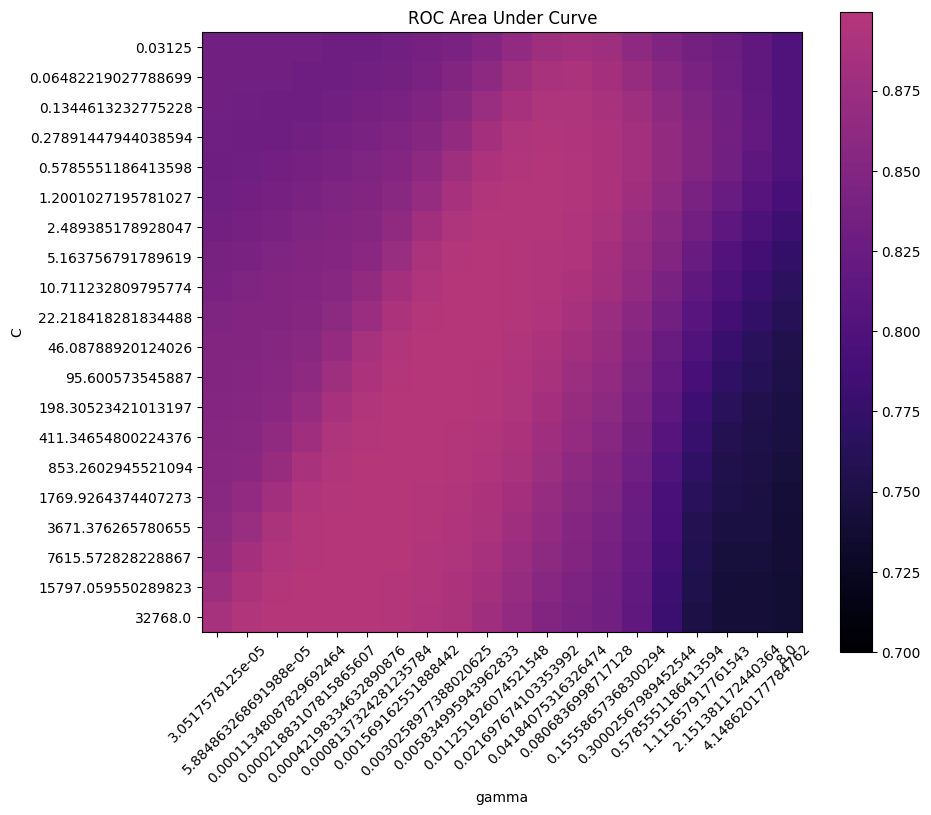

Best parameters:  {'svc__C': 32768.0, 'svc__gamma': 0.00042198334632890876}
Best cross-validation accuracy:  0.8995132989365224


In [40]:
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["svc__C"]), len(grid.param_grid["svc__gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.magma,
               norm=MidpointNormalize(vmin=0.7, midpoint=0.9))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["svc__gamma"])), grid.param_grid["svc__gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["svc__C"])), grid.param_grid["svc__C"])
    plt.title('ROC Area Under Curve')
    plt.show()
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")
plotSearchGrid(grid)
print("Best parameters: ", grid.best_params_)
print("Best cross-validation accuracy: ", grid.best_score_)

The results from the grid search tell us that the SVM performs best with a very high value for C and a very low value for gamma.
- The high C suggests that the best model has a complex decision decision boundary that benefits from fitting the training data closely.
- The low gamma indicates that a larger kernel which smoothes the decision boundary works best.
Together, the low gamma is likely to counteract the tendacy of a high C value to overfit the training data while still being able to capture a complex interaction between our mixed type variables.

## Results from models

| Model                     | Weighted Avg Precision | Weighted Avg Recall | Accuracy | Weighted Avg F1-score | AUC-ROC |
|---------------------------|-------------------------|----------------------|----------|-----------------------|---------|
| Logistic Regression       | 0.81                   | 0.77                 | 0.77     | 0.78                 | 0.85    |
| SVM Baseline              | 0.82                   | 0.83                 | 0.83     | 0.82                 | 0.82    |
| SVM with Class Weights    | 0.81                   | 0.80                 | 0.80     | 0.80                 | 0.85    |
| SVM with Hyperparameter Tuning | 0.85              | 0.79                 | 0.79     | 0.80                 | 0.90    |

There are a few takeaways from comparing the results from our models.
- The baseline SVM outperforms the logistic regression in accuracy and recall, but has a lower AUC-ROC. It may struggle with overall class separation.
- The SVM with Class Weights acheives similar results to Logistic Regression showing that incorporating class weights helps address the dataset's imbalance but does not significantly outperform Logistic Regression.
- Finally, the SVM with Hyperparameter Tuning shows the best overall performance acheiving the highest AUC-ROC of 0.90. This indicates that careful tuning of hyperparameters significantly improves the model's ability to distinguish between classes, making it the most effective choice for this classification task.

# Iteratively removing features

In [44]:
for column in list(df.dtypes.index):
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.834
workclasscross-val mean-accuracy: 0.838
educationcross-val mean-accuracy: 0.839
education_numcross-val mean-accuracy: 0.823
marital_statuscross-val mean-accuracy: 0.836
occupationcross-val mean-accuracy: 0.839
relationshipcross-val mean-accuracy: 0.835
racecross-val mean-accuracy: 0.839
sexcross-val mean-accuracy: 0.837
capital_gaincross-val mean-accuracy: 0.810
capital_losscross-val mean-accuracy: 0.830
hours_per_weekcross-val mean-accuracy: 0.842
native_countrycross-val mean-accuracy: 0.843
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30139 non-null  int64
 1   workclass       30139 non-null  int32
 2   education       30139 non-null  int32
 3   education_num   30139 non-null  int64
 4   marital_status  30139 non-null  int32
 5   occupation      30139 non-null  int32
 6   relationship   

In [16]:
for column in list(df.dtypes.index):
    if (column != 'income') & (column != 'native_country'):
        y = df['income']
        X = df.drop(columns=['income', 'native_country', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.837
workclasscross-val mean-accuracy: 0.842
educationcross-val mean-accuracy: 0.842
education_numcross-val mean-accuracy: 0.827
marital_statuscross-val mean-accuracy: 0.842
occupationcross-val mean-accuracy: 0.843
relationshipcross-val mean-accuracy: 0.839
racecross-val mean-accuracy: 0.844
sexcross-val mean-accuracy: 0.842
capital_gaincross-val mean-accuracy: 0.812
capital_losscross-val mean-accuracy: 0.834
hours_per_weekcross-val mean-accuracy: 0.845
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30139 non-null  int64
 1   workclass       30139 non-null  int32
 2   education       30139 non-null  int32
 3   education_num   30139 non-null  int64
 4   marital_status  30139 non-null  int32
 5   occupation      30139 non-null  int32
 6   relationship    30139 non-null  int32
 7   race            3

In [17]:
drops = list(df.dtypes.index)
print(drops)
drops.remove('hours_per_week') #ACC: 0.845
print(drops)
drops.remove('native_country')
print(drops)

['age', 'workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
['age', 'workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'native_country', 'income']
['age', 'workclass', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'income']


In [18]:
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.840
workclasscross-val mean-accuracy: 0.844
educationcross-val mean-accuracy: 0.847
education_numcross-val mean-accuracy: 0.822
marital_statuscross-val mean-accuracy: 0.844
occupationcross-val mean-accuracy: 0.847
relationshipcross-val mean-accuracy: 0.840
racecross-val mean-accuracy: 0.844
sexcross-val mean-accuracy: 0.843
capital_gaincross-val mean-accuracy: 0.811
capital_losscross-val mean-accuracy: 0.837
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30139 non-null  int64
 1   workclass       30139 non-null  int32
 2   education       30139 non-null  int32
 3   education_num   30139 non-null  int64
 4   marital_status  30139 non-null  int32
 5   occupation      30139 non-null  int32
 6   relationship    30139 non-null  int32
 7   race            30139 non-null  int32
 8   sex             301

In [19]:
drops.remove('education') #ACC: 0.847
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.830
workclasscross-val mean-accuracy: 0.847
education_numcross-val mean-accuracy: 0.823
marital_statuscross-val mean-accuracy: 0.846
occupationcross-val mean-accuracy: 0.847
relationshipcross-val mean-accuracy: 0.843
racecross-val mean-accuracy: 0.847
sexcross-val mean-accuracy: 0.846
capital_gaincross-val mean-accuracy: 0.813
capital_losscross-val mean-accuracy: 0.838
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30139 non-null  int64
 1   workclass       30139 non-null  int32
 2   education_num   30139 non-null  int64
 3   marital_status  30139 non-null  int32
 4   occupation      30139 non-null  int32
 5   relationship    30139 non-null  int32
 6   race            30139 non-null  int32
 7   sex             30139 non-null  int32
 8   capital_gain    30139 non-null  int64
dtypes: int32(6), int6

In [20]:
drops.remove('workclass') #ACC: 0.847
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', column])
        #X.info()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.829
education_numcross-val mean-accuracy: 0.823
marital_statuscross-val mean-accuracy: 0.846
occupationcross-val mean-accuracy: 0.847
relationshipcross-val mean-accuracy: 0.843
racecross-val mean-accuracy: 0.848
sexcross-val mean-accuracy: 0.846
capital_gaincross-val mean-accuracy: 0.813
capital_losscross-val mean-accuracy: 0.835
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30139 non-null  int64
 1   education_num   30139 non-null  int64
 2   marital_status  30139 non-null  int32
 3   occupation      30139 non-null  int32
 4   relationship    30139 non-null  int32
 5   race            30139 non-null  int32
 6   sex             30139 non-null  int32
 7   capital_gain    30139 non-null  int64
dtypes: int32(5), int64(3)
memory usage: 1.5 MB


In [21]:
drops.remove('race') #ACC 0.848 MAX
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', column])        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.829
education_numcross-val mean-accuracy: 0.823
marital_statuscross-val mean-accuracy: 0.846
occupationcross-val mean-accuracy: 0.846
relationshipcross-val mean-accuracy: 0.843
sexcross-val mean-accuracy: 0.845
capital_gaincross-val mean-accuracy: 0.813
capital_losscross-val mean-accuracy: 0.836
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30139 non-null  int64
 1   education_num   30139 non-null  int64
 2   marital_status  30139 non-null  int32
 3   occupation      30139 non-null  int32
 4   relationship    30139 non-null  int32
 5   sex             30139 non-null  int32
 6   capital_gain    30139 non-null  int64
dtypes: int32(4), int64(3)
memory usage: 1.4 MB


In [22]:
drops.remove('marital_status') #ACC 0.846
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', 'marital_status', column])
        #X.info()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.824
education_numcross-val mean-accuracy: 0.823
occupationcross-val mean-accuracy: 0.844
relationshipcross-val mean-accuracy: 0.839
sexcross-val mean-accuracy: 0.844
capital_gaincross-val mean-accuracy: 0.811
capital_losscross-val mean-accuracy: 0.835
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            30139 non-null  int64
 1   education_num  30139 non-null  int64
 2   occupation     30139 non-null  int32
 3   relationship   30139 non-null  int32
 4   sex            30139 non-null  int32
 5   capital_gain   30139 non-null  int64
dtypes: int32(3), int64(3)
memory usage: 1.3 MB


In [23]:
drops.remove('sex') #ACC 0.844
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', 'marital_status', 'sex', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.824
education_numcross-val mean-accuracy: 0.823
occupationcross-val mean-accuracy: 0.842
relationshipcross-val mean-accuracy: 0.832
capital_gaincross-val mean-accuracy: 0.810
capital_losscross-val mean-accuracy: 0.833
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            30139 non-null  int64
 1   education_num  30139 non-null  int64
 2   occupation     30139 non-null  int32
 3   relationship   30139 non-null  int32
 4   capital_gain   30139 non-null  int64
dtypes: int32(2), int64(3)
memory usage: 1.1 MB


In [24]:
drops.remove('occupation') #ACC 0.842
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', 'marital_status', 'sex', 'occupation', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.824
education_numcross-val mean-accuracy: 0.823
relationshipcross-val mean-accuracy: 0.832
capital_gaincross-val mean-accuracy: 0.810
capital_losscross-val mean-accuracy: 0.832
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            30139 non-null  int64
 1   education_num  30139 non-null  int64
 2   relationship   30139 non-null  int32
 3   capital_gain   30139 non-null  int64
dtypes: int32(1), int64(3)
memory usage: 1.0 MB


In [25]:
drops.remove('relationship') #ACC 0.832
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', 'marital_status', 'sex', 'occupation',
                             'relationship', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

agecross-val mean-accuracy: 0.824
education_numcross-val mean-accuracy: 0.823
capital_gaincross-val mean-accuracy: 0.802
capital_losscross-val mean-accuracy: 0.821
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            30139 non-null  int64
 1   education_num  30139 non-null  int64
 2   capital_gain   30139 non-null  int64
dtypes: int64(3)
memory usage: 941.8 KB


In [26]:
drops.remove('age') #ACC 0.824
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', 'marital_status', 'sex', 'occupation',
                             'relationship', 'age', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

education_numcross-val mean-accuracy: 0.824
capital_gaincross-val mean-accuracy: 0.775
capital_losscross-val mean-accuracy: 0.808
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   education_num  30139 non-null  int64
 1   capital_gain   30139 non-null  int64
dtypes: int64(2)
memory usage: 706.4 KB


In [27]:
drops.remove('education_num') #ACC 0.824
for column in drops:
    if column != 'income':
        y = df['income']
        X = df.drop(columns=['income', 'native_country', 'hours_per_week', 'education', 'workclass', 'race', 'marital_status', 'sex', 'occupation',
                             'relationship', 'age', 'education_num', column])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        nlsvm = SVC(C=1.7284437865632103, kernel='rbf', gamma=0.00504273124198205)
        nlsvm.fit(X_train,y_train)
        scores = cross_val_score(nlsvm, X_test, y_test)
        print(column + "cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
    else:
        X.info()

capital_gaincross-val mean-accuracy: 0.775
capital_losscross-val mean-accuracy: 0.808
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   capital_gain  30139 non-null  int64
dtypes: int64(1)
memory usage: 470.9 KB


We were able to remove 'native_country', 'hours_per_week', 'education', 'workclass', 'race' which increased accuracy up to .849. These are likely the less importance factors to determinig income and this matches up with our analysis in the EDA which indicated highly imbalanced features would be less important. 

# Discussion and Conclusions

We were able to get and model that performed well with hyperparameter tuning and class weighting to address the class imbalance. In the future we could expand our grid search to values even higher for C, since our highest performing model was at the highest value of C that we tested. Another thing we could experiment with is undersampling our minority class to make and balanced dataset, or we could potentially collect more data.